In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
import h5py

In [26]:
h5 = h5py.File('/data/readout/archive/2015-11-14-timeseries-for-brad.h5','w')

In [2]:
import kid_readout.analysis.archive

/home/local/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


updated file list


In [3]:
pkls = kid_readout.analysis.archive.load_noise_pkl('/data/readout/pkl/2015-09-29_141610_long_timestream.pkl')

In [4]:
pkl= pkls[0]

In [5]:
pkl.timestream_duration

2147.4836479999999

The normalized timeseries has had the cable delay and arbitrary gain and phase removed

In [6]:
ts = pkl.normalized_timeseries[:]

In [27]:
ds = h5.create_dataset('normalized_timeseries',shape=ts.shape,dtype=ts.dtype,data=ts)

In [7]:
import kid_readout.analysis.resonator

Next, we convert the normalized timeseries to fractional frequency fluctuation (detuning) using the model fit to the resonance sweep

In [8]:
x = kid_readout.analysis.resonator.normalized_s21_to_detuning(ts,pkl.resonator_model)

In [28]:
ds = h5.create_dataset('fractional_fluctuation',shape=x.shape,dtype=x.dtype,data=x)

In [9]:
import kid_readout.utils.despike

Next we despike the data

In [10]:
xds = kid_readout.utils.despike.deglitch_window(x,2**12)

/home/gjones/kid_readout/kid_readout/utils/fftfilt.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i:k] = y[i:k] + yt[:k-i]            # and add


In [29]:
ds = h5.create_dataset('despiked_fractional_fluctuation',shape=xds.shape,dtype=xds.dtype,data=xds)

In [30]:
h5.close()

In the following, I discard the first 2**20 samples because of some transient behavior (temperature stabilization?)

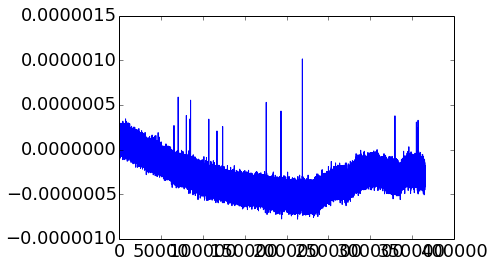

In [33]:
plot(xds[2**20::89])

Remove any mean and compute the power spectrum

In [13]:
pxx,fr = mlab.psd(xds[2**20:]-xds[2**20:].mean(),NFFT=2**20,Fs=256e6/2**14)

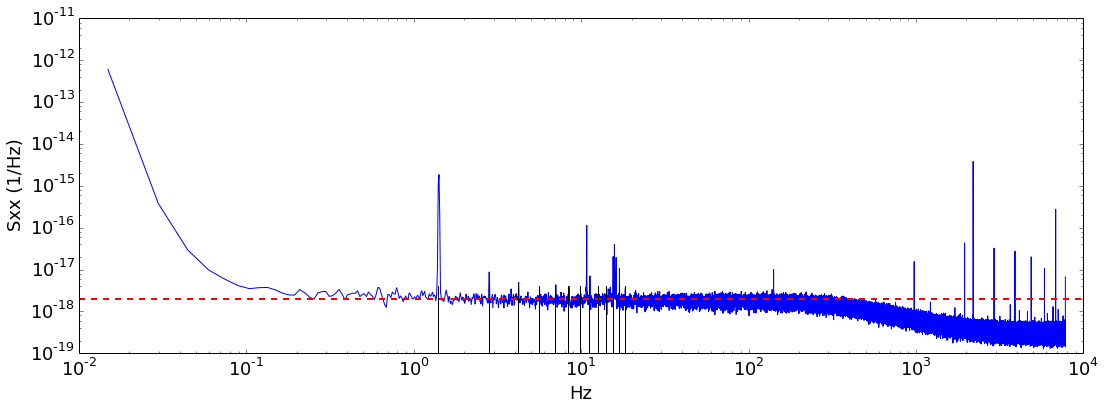

In [15]:
rcParams['font.size']=18
figure(figsize=(18,6))
loglog(fr,pxx)
gca().axhline(2e-18,color='r',linestyle='--',lw=2) # straight line to guide the eye
for k in range(14):
    gca().axvline(k*1.4,ymax=0.2,color='k')  # first few pulse tube harmonics
ylabel('Sxx (1/Hz)')
xlabel('Hz')


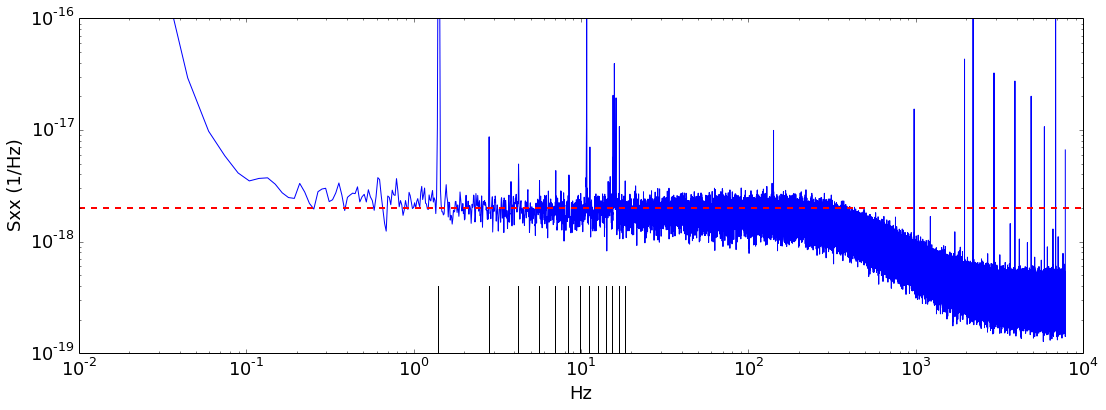

In [16]:
figure(figsize=(18,6))
loglog(fr,pxx)
ylim(1e-19,1e-16)
gca().axhline(2e-18,color='r',linestyle='--',lw=2)
for k in range(14):
    gca().axvline(k*1.4,ymax=0.2,color='k')
ylabel('Sxx (1/Hz)')
xlabel('Hz')


In [34]:
def deglitch_mask_block_mad(ts,thresh=5,mask_extend=50,debug=False):
    median = np.median(ts)
    deviations = np.abs(ts-median)
    mad = np.median(deviations)
    mask = deviations > (mad*thresh)
    if debug:
        plot(deviations)
        plot(mask*deviations.max(),'o')
    new_mask = mask.copy()
    for offset in range(1,mask_extend):
        new_mask[:-offset] |= mask[offset:]
        new_mask[offset:] |= mask[:-offset]
    mask = new_mask
#    mask[:-mask_extend] = (~mask[:-mask_extend] | ~mask[mask_extend:])
#    mask[mask_extend:] = mask[mask_extend:] | mask[:-mask_extend]
    if debug:
        plot(mask*deviations.max(),'x',mew=2)
    return mask
def deglitch_mask_mad(ts,thresh=5,mask_extend=50,window_length=2**8):
    full_mask = np.zeros(ts.shape,dtype='bool')
    step = window_length//2
    nstep = ts.shape[0]//step
    for k in xrange(nstep):
        start = k-1
        if start < 0:
            start = 0
        chunk = ts[start*step:(k+1)*step]
        mask = deglitch_mask_block_mad(chunk,thresh=thresh,mask_extend=mask_extend)
        full_mask[start*step:((start+1)*step)] |= mask[:step]
    full_mask[start*step:start*step+len(mask)] |= mask
    return full_mask

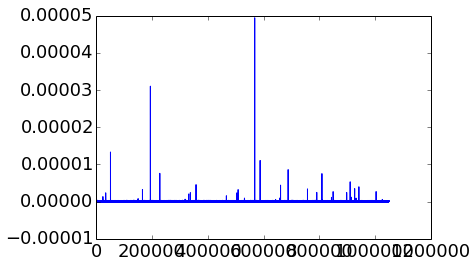

In [35]:
plot(x[2**20:2**21])

In [78]:
mask = deglitch_mask_mad(x,thresh=7,mask_extend=20,window_length=2**10)

In [101]:
clean = x.copy()
clean[mask] = clean[np.roll(mask,126)]

In [83]:
x.shape

(33554432,)

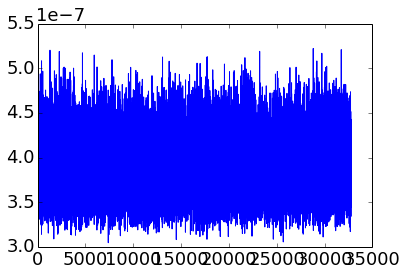

In [116]:
c2 = clean.reshape((-1,2**10))
plot(c2.ptp(1))

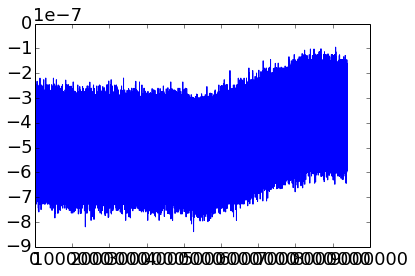

In [109]:
plot(clean[2**24:2**24+2**23])

In [117]:
h5 = h5py.File('/data/readout/archive/2015-11-15-clean-long-timeseries.h5','w')

In [118]:
ds = h5.create_dataset('clean_fractional_fluctuation',shape=clean.shape,dtype=clean.dtype,data=clean)

In [119]:
h5.close()

In [102]:
clean.max()

3.6754992e-07

In [103]:
clean.min()

-8.3898431e-07

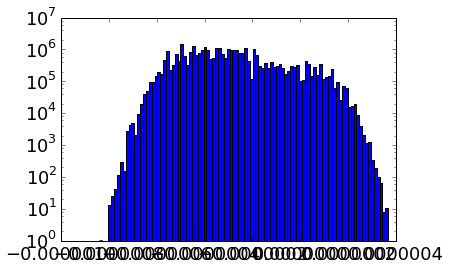

In [104]:
blah = hist(clean,bins=100,log=True)

In [105]:
pxx_clean,fr_clean = mlab.psd(clean[2**20:]-clean[2**20:].mean(),NFFT=2**20,Fs=256e6/2**14)

In [134]:
pxx_dirty,fr_clean = mlab.psd(x[2**20:]-x[2**20:].mean(),NFFT=2**20,Fs=256e6/2**14)

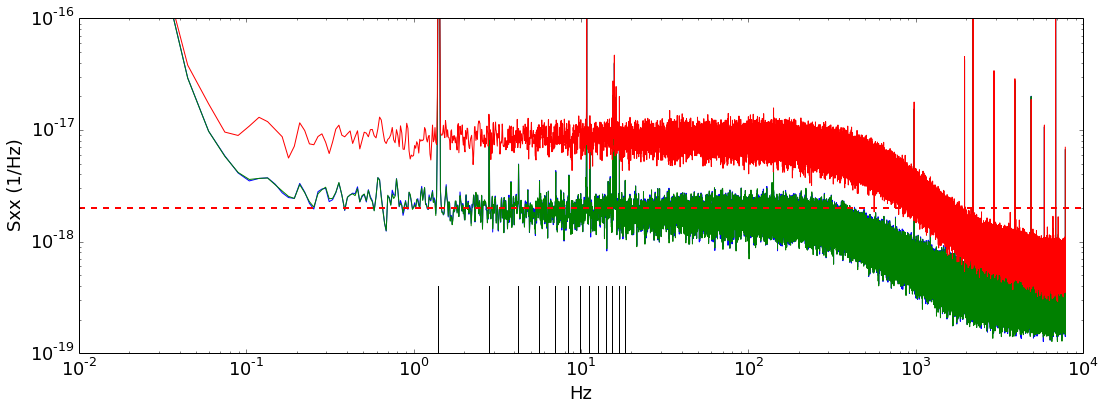

In [136]:
figure(figsize=(18,6))
loglog(fr,pxx)
loglog(fr_clean,pxx_clean)
loglog(fr_clean,pxx_dirty)
ylim(1e-19,1e-16)
gca().axhline(2e-18,color='r',linestyle='--',lw=2)
for k in range(14):
    gca().axvline(k*1.4,ymax=0.2,color='k')
ylabel('Sxx (1/Hz)')
xlabel('Hz')


(34000, 34200)

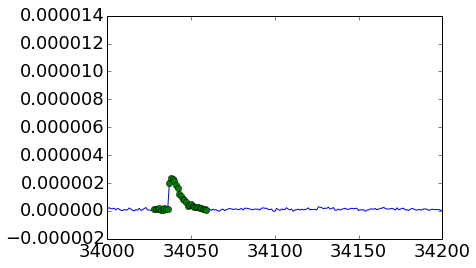

In [64]:
plot(x[2**20:2**20+100000])
plot(np.flatnonzero(mask),x[2**20:2**20+100000][mask],'o')
xlim(34000,34200)

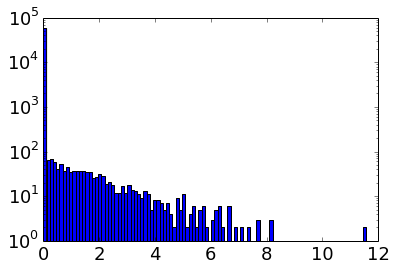

In [132]:
blah = hist(np.diff(np.flatnonzero(mask))/15625.,bins=100,log=True)